In [30]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from os import path
import sys
sys.path.insert(0, path.abspath('../'))

from src.mcmc import Chain
from src import parse_model_parameter_file


log="no_log"
pca="no_pca"
log2="nolog"
pca2="nopca"
setup="allenergies:allsystems:base-star-eta:3.0:nostarptcut_nolog_nopca_PCGP_full"
setup2="allenergies:allsystems:base-star-eta:3.0:nostarptcut"
suff=""
emu="PCGP"

In [31]:
def read_pkl_file_chain(PATH_pklfile_chains):
    with open(PATH_pklfile_chains, 'rb') as pf:
        data = pickle.load(pf)
    
    chain = data['chain']
    #print(data['log_likelihood'])
    print(chain.shape)
    n_walkers = chain.shape[0]
    n_parameters = chain.shape[1]

    return n_walkers, n_parameters, data['chain']

In [32]:
#loading the chain file
#TODO WHAT IS THIS PARAMETERS??
dNcencut = 7  
vncencut = 6

nameStr = "Name"
#nwalkers, nsteps, ndim, chain_pkl = read_pkl_file_chain(path.join("mcmc", "chain.pkl"))[3]
file_path_mcmc=path.join("/home/niklas/Desktop/lustre/good_bayes/inference/actual/mcmc_full/"+log+"/"+pca+"/"+emu, "data:"+setup2+"_"+log2+"_"+pca2+"_"+emu+"_full"+suff+".pkl")
nsteps, ndim, chain_pkl = read_pkl_file_chain(file_path_mcmc)
chain = np.nan_to_num(chain_pkl)

(70964, 15)


In [33]:
# get the posterior parameters
samples = chain.reshape(-1, ndim)

# print out the MAP parameters
results = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
              zip(*np.percentile(samples, [16, 50, 84], axis=0)))
mapParam = []
for ipar, par in enumerate(list(results)):
    print("%s = %.4f^{+%.4f}_{-%.4f}" % (
        ipar, par[0], par[1], par[2]))
    mapParam.append(par[0])

# define the relevant mcmc object
exp_path = "/home/niklas/Desktop/lustre/good_bayes/inference/exp/data:"+setup2+".pkl"
model_par = '/home/niklas/Desktop/lustre/good_bayes/inference/training_points/configs/config_AuAu_200_bulk_scan_central.yaml'
mymcmc = Chain(expdata_path=exp_path, model_parafile=model_par)
emuPath=["/home/niklas/Desktop/lustre/good_bayes/inference/actual/emulator_full/"+log+"/"+pca+"/"+emu+"/data:"+setup2+"_"+log2+"_"+pca2+"_"+emu+suff]

mymcmc.loadEmulator(emuPath)
expData = mymcmc._read_in_exp_data_pickle(exp_path)



0 = 1.3405^{+0.2889}_{-0.3019}
1 = -11.7024^{+4.6039}_{-2.2125}
2 = -12.5323^{+7.8258}_{-1.6009}
3 = 0.5029^{+0.1612}_{-0.1668}
4 = 0.2185^{+0.0832}_{-0.0994}
5 = 3.2318^{+3.3766}_{-2.7164}
6 = 0.0373^{+0.3290}_{-0.2110}
7 = 0.6321^{+0.7465}_{-0.3018}
8 = 1.6955^{+0.3611}_{-0.6767}
9 = 0.1313^{+0.0395}_{-0.0267}
10 = 0.0916^{+0.0675}_{-0.0582}
11 = 25.7295^{+10.2582}_{-15.2152}
12 = 0.0589^{+0.0289}_{-0.0344}
13 = 0.0824^{+0.0457}_{-0.0480}
14 = 0.9769^{+0.1451}_{-0.1240}
[INFO][mcmc] Initializing MCMC ...
[INFO][mcmc] Final Markov Chain results will be saved in mcmc/chain.pkl
[INFO][mcmc] Loading the model parameters space from /home/niklas/Desktop/lustre/good_bayes/inference/training_points/configs/config_AuAu_200_bulk_scan_central.yaml ...
[INFO][mcmc] Run MCMC with emcee...
[INFO][mcmc] Loading the experiment data from /home/niklas/Desktop/lustre/good_bayes/inference/exp/data:allenergies:allsystems:base-star-eta:3.0:nostarptcut.pkl ...
[INFO][mcmc] Experimental dataset size: 168
[I

In [34]:
# setup the MCMC Chain
#-> is it correct to set up a new one here?
#yes, because we just use the emulator
rng = np.random.default_rng()
#print(samples.shape)
sampleIdxList = rng.choice(samples.shape[0], 3000, replace=False) #choose 15 random samples for parameter prediction
posteriorSamples = samples[sampleIdxList, :]
#print(posteriorSamples.shape)
postPred = mymcmc._predict(posteriorSamples) #convert the 15 parameters to posterior predictons
postPred = postPred[0].transpose()
nsamples = postPred.shape[1]
#print(postPred.shape)


In [35]:
# #TODO is there really no convergence?
# #emulators are good, PCA consistently worse for them (issue?)
# #log could be an issue, but his log has some problem with the log_likelihood
# #it shows that convergence is possible, but it is not clear why it didn't happen with others also
# #TODO adapt
# #Convergence still not fixed. Is the problem in the visualisation? Why are some regions not sampled into at all?
# #TODO debug with chatty? use other MCMC?
# # WHY Is not the whole region covered?
# #Plan: use first other mcmc, because I have to figure out why not whole region covered
prior_ranges = [
    (0.8,2.5),
    (-15,1.75),
    (-15,1),
    (0.25,0.75),
    (0.001,0.35),
    (-0.8,9),
    (-0.3,0.8),
    (0.2,2.2),
    (0.2,3),
    (0.09,0.25),
    (0,0.2),
    (0.5,40),
    (0.005,0.1),
    (0.01,0.15),
    (0.8,1.2),
] 
PARAMETER_NAMES = [
    r'$\tau_{IC,scale}\;({\rm fm})$',
    r'$a_{h,\eta}$',
    r'$a_{l,\eta}$',
    r'$\epsilon_{\rm sw}\;({\rm GeV/fm^3})$',
    r'$(\eta/s)_{\rm min}$',
    r'$a_{\mu_B}$', #etsscale_mub
    r'$b_{\mu_B}$',#etasshiftmub
    r'$R_{\perp}$',
    r'$R_{\eta}$',
    r'$T_{\eta, \rm 0}\;({\rm GeV})$',
    r'$(\zeta/s)_{\rm 0}$',
    r'$(\epsilon)_{\zeta,\rm 0 }\;({\rm GeV/fm^3})$',
    r'$\sigma_{\zeta, \rm -}\;({\rm GeV})$',
    r'$\sigma_{\zeta, \rm +}\;({\rm GeV})$',
    r'$\sigma_{\rm AB, scale}$'
]
# def plot_chain_histogram(n_parameters, data_array, true_values=None):
#     num_columns = 3

#     # Calculate the number of rows needed based on the number of parameters and columns
#     num_rows = (n_parameters + num_columns - 1) // num_columns

#     # Define the height of each subplot
#     subplot_height = 1.25

#     # Calculate the total height of the figure
#     total_height = subplot_height * num_rows

#     fig, axs = plt.subplots(num_rows, num_columns, figsize=(10, total_height), sharex=False)
#     axs = axs.flatten()

#     for param_index in range(n_parameters):
#         # Create a 2D histogram
#         concatenated_data = data_array[ :, param_index].reshape(-1)
#         #print(concatenated_data)
#         hist, xedges, yedges = np.histogram2d(np.arange(nsteps), concatenated_data.flatten(), bins=30)
#         hist = np.ma.masked_where(hist == 0, hist)  # Mask empty bins
#         im = axs[param_index].pcolormesh(xedges, yedges, hist.T, cmap='Greens')

#         if true_values is not None:
#             axs[param_index].axhline(true_values[param_index], color='k', linestyle='--', alpha=0.5)

#         axs[param_index].set_ylabel(PARAMETER_NAMES[param_index])
#         axs[param_index].set_xlim([0., max(xedges)])
#         axs[param_index].set_ylim([np.min( concatenated_data.flatten()), np.max( concatenated_data.flatten())])
#         #axs[param_index].set_ylim([-2,2])
#     # Specify indices for which to display x-axis labels
#     indices_with_labels = [12, 13, 14]

#     # Set x-axis labels and numbers for specified indices
#     for i, ax in enumerate(axs):
#         if i in indices_with_labels:
#             ax.set_xlabel('Steps')
#         else:
#             ax.set_xticklabels([])

#     # Hide the empty subplots
#     for i in range(n_parameters, num_columns * num_rows):
#         fig.delaxes(axs[i])

#     plt.subplots_adjust(wspace=0)
#     plt.tight_layout()
#     plt.show()

# plot_chain_histogram( 15, chain, true_values=None)

In [36]:
# def plot_trace(chain, param_names):
#     n_params = chain.shape[1]
#     fig, axs = plt.subplots(n_params, figsize=(10, 2 * n_params), sharex=True)
#     for i in range(n_params):
#         axs[i].plot(chain[:, i], lw=0.5)
#         axs[i].set_ylabel(param_names[i])
#     axs[-1].set_xlabel("Steps")
#     plt.tight_layout()
#     plt.show()

# plot_trace(chain, PARAMETER_NAMES)

[INFO][_mathtext] Substituting symbol \perp from STIXGeneral
[INFO][_mathtext] Substituting symbol \perp from STIXGeneral
[INFO][_mathtext] Substituting symbol \perp from STIXGeneral
[INFO][_mathtext] Substituting symbol \perp from STIXGeneral
[INFO][_mathtext] Substituting symbol \perp from STIXGeneral
[INFO][_mathtext] Substituting symbol \perp from STIXGeneral
[INFO][_mathtext] Substituting symbol \perp from STIXGeneral
[INFO][_mathtext] Substituting symbol \perp from STIXGeneral


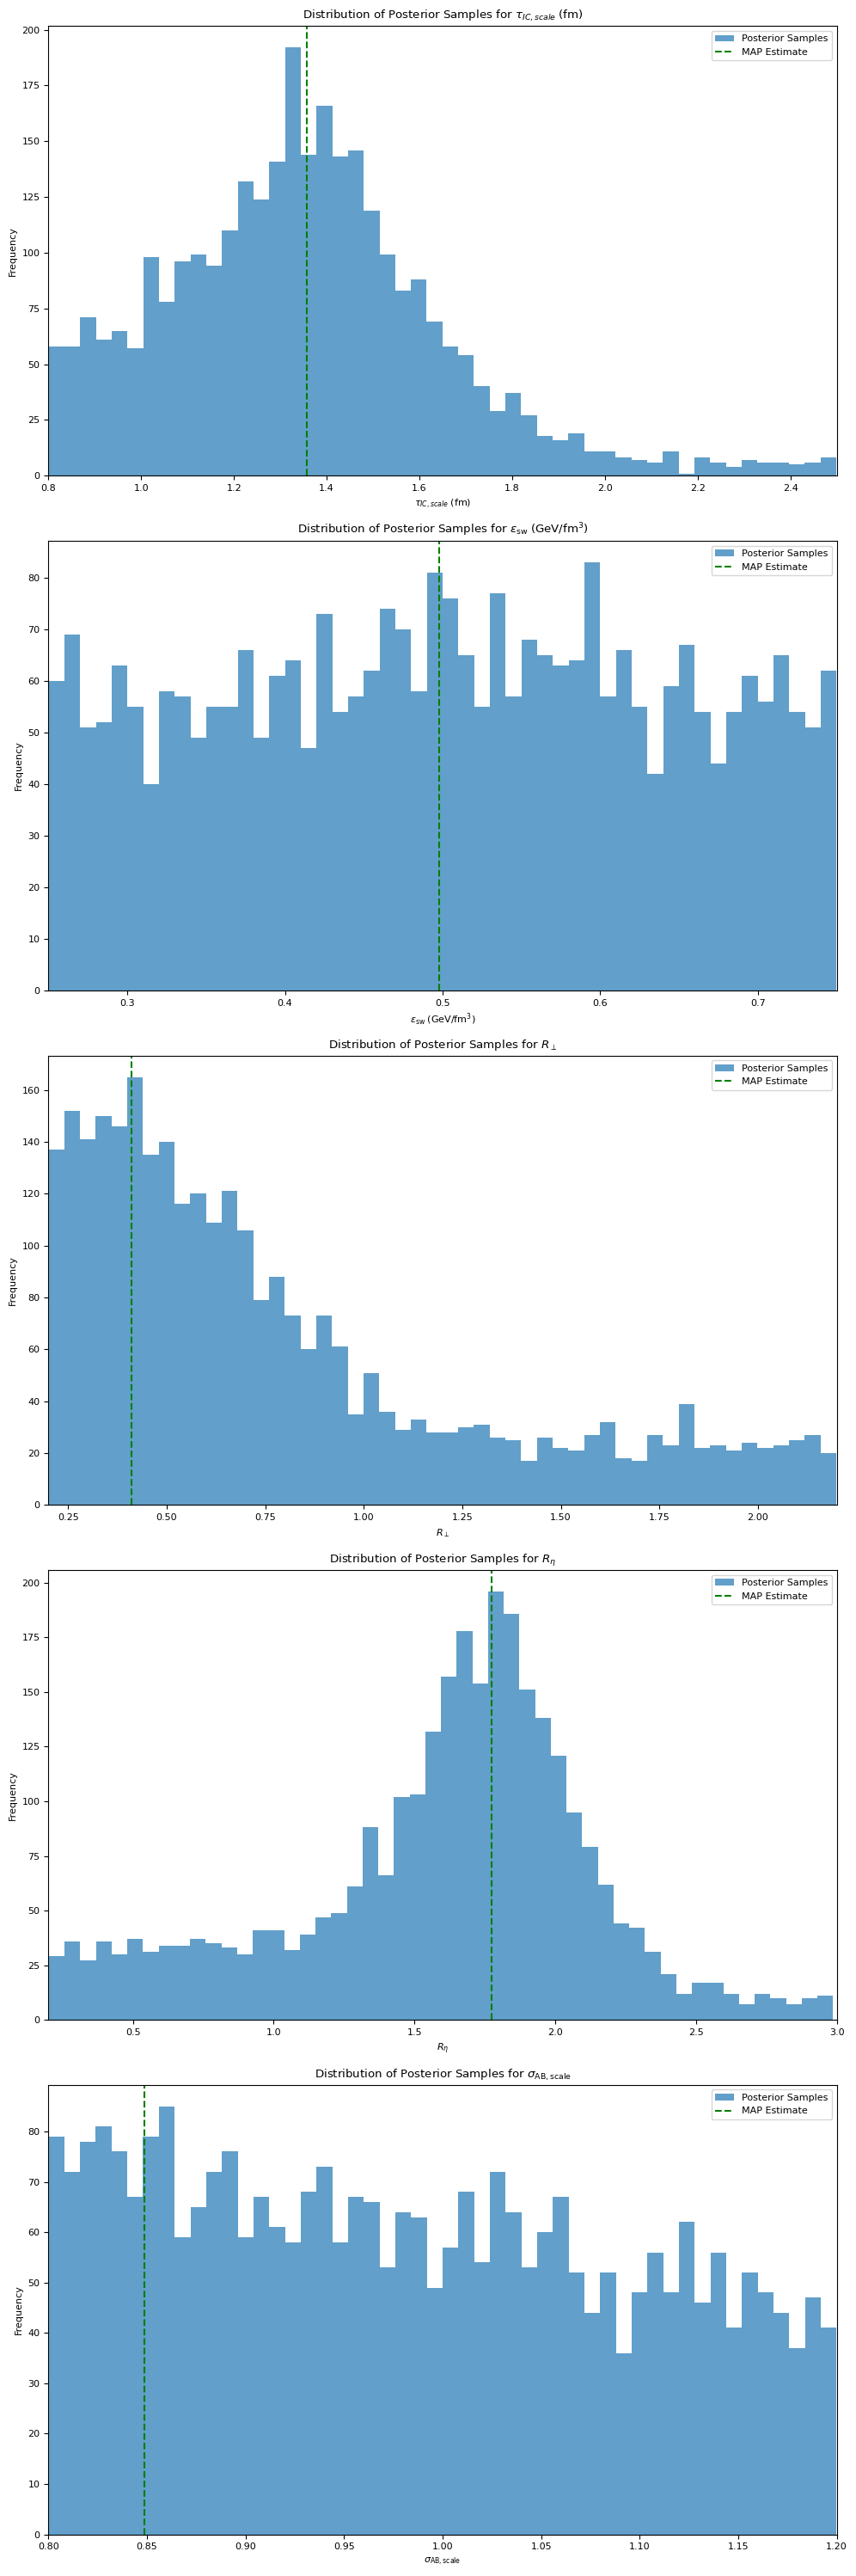

In [37]:
# import matplotlib.pyplot as plt
# import numpy as np
# from scipy.stats import mode
from scipy.stats import gaussian_kde
# #TODO the distribution is flat, something is odd here
# #also what is happening to the model parameter, why out of distribution

# def extract_model_parameters():
#     # Placeholder for actual model parameters extraction logic
#     return parameters

def calculate_map_estimates(posteriorSamples):
    map_estimates = []
    for i in range(posteriorSamples.shape[1]):
        kde = gaussian_kde(posteriorSamples[:, i])
        x_vals = np.linspace(np.min(posteriorSamples[:, i]), np.max(posteriorSamples[:, i]), 1000)
        kde_vals = kde(x_vals)
        mode_idx = np.argmax(kde_vals)
        map_estimates.append(x_vals[mode_idx])
    return map_estimates

def plot_distribution_of_posterior_samples(posteriorSamples, mapEstimates):
    n_parameters = posteriorSamples.shape[1]
    
    fig, axes = plt.subplots(5, 1, figsize=(10, 6 * 5))
    count=0
    for i in [0,3,7,8,14]:
        ax = axes[count] if n_parameters > 1 else axes
        count=count+1
        ax.hist(posteriorSamples[:, i], bins=50, alpha=0.7, label='Posterior Samples')
        #ax.axvline(modelParameters[i], color='r', linestyle='--', label='Model Parameter')
        ax.axvline(mapEstimates[i], color='g', linestyle='--', label='MAP Estimate')
        ax.set_xlabel(PARAMETER_NAMES[i])
        ax.set_ylabel('Frequency')
        ax.set_title(f'Distribution of Posterior Samples for {PARAMETER_NAMES[i]}')
        ax.set_xlim([prior_ranges[i][0], prior_ranges[i][1]])
        ax.legend()
    
    plt.tight_layout()
    #plt.savefig("closure_05_2030.png")
    plt.show()

# Assuming posteriorSamples is already defined
#posteriorSamples = np.random.randn(1000, 15)  # Example posterior samples for demonstration

# # Extract model parameters
# modelParameters = extract_model_parameters()

# Calculate MAP estimates
mapEstimates = calculate_map_estimates(posteriorSamples)

# Call the plotting function
plot_distribution_of_posterior_samples(posteriorSamples, mapEstimates)

/tmp/ipykernel_768737/2323280082.py:37: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  kde_vals /= np.trapz(kde_vals, x_vals)  # Normalize the area under the curve


[INFO][_mathtext] Substituting symbol \perp from STIXGeneral
[INFO][_mathtext] Substituting symbol \perp from STIXGeneral
[INFO][_mathtext] Substituting symbol \perp from STIXGeneral
[INFO][_mathtext] Substituting symbol \perp from STIXGeneral
[INFO][_mathtext] Substituting symbol \perp from STIXGeneral
[INFO][_mathtext] Substituting symbol \perp from STIXGeneral
[INFO][_mathtext] Substituting symbol \perp from STIXGeneral
[INFO][_mathtext] Substituting symbol \perp from STIXGeneral


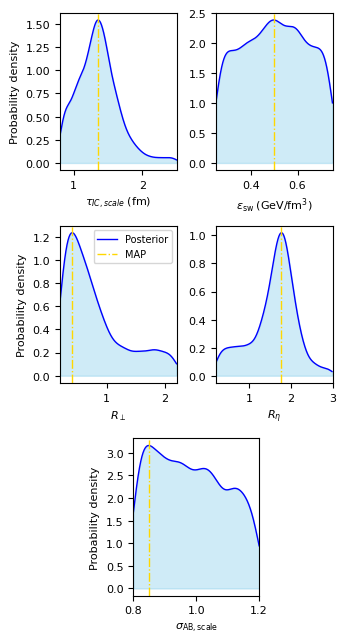

In [38]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.gridspec as gridspec


# Assuming posteriorSamples, prior_ranges, and PARAMETER_NAMES are already defined

def calculate_map_estimates(posteriorSamples):
    map_estimates = []
    for i in range(posteriorSamples.shape[1]):
        kde = gaussian_kde(posteriorSamples[:, i])
        x_vals = np.linspace(np.min(posteriorSamples[:, i]), np.max(posteriorSamples[:, i]), 1000)
        kde_vals = kde(x_vals)
        mode_idx = np.argmax(kde_vals)
        map_estimates.append(x_vals[mode_idx])
    return map_estimates


def plot_distribution_of_posterior_samples(posteriorSamples, mapEstimates):
    fig = plt.figure(figsize=(3.5, 3*3.5/(1.618)))
    gs = gridspec.GridSpec(3, 2, figure=fig)  # Create a 4x2 grid for better control

    # Create subplots for the 5 variables and the last one centered in a new row
    axes = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1]),
            fig.add_subplot(gs[1, 0]), fig.add_subplot(gs[1, 1]),
            fig.add_subplot(gs[2, :])]  # Span the last one across both columns
    count = 0
    for i in [0, 3, 7, 8, 14]:
        ax = axes[count]
        count += 1

        # KDE for smooth distribution
        kde = gaussian_kde(posteriorSamples[:, i])
        x_vals = np.linspace(np.min(posteriorSamples[:, i]), np.max(posteriorSamples[:, i]), 1000)
        kde_vals = kde(x_vals)
        kde_vals /= np.trapz(kde_vals, x_vals)  # Normalize the area under the curve

        # Extend the x_vals and kde_vals to touch the y=0 line at both ends
        x_extended = np.concatenate(([prior_ranges[i][0]], x_vals, [prior_ranges[i][1]]))
        kde_extended = np.concatenate(([0], kde_vals, [0]))

        # Plot the smoothed distribution and fill the area under the curve
        ax.plot(x_vals, kde_vals, label='Posterior', color='b', lw=1)
        ax.fill_between(x_extended, kde_extended, color='skyblue', alpha=0.4, zorder=1)

        # Plot vertical lines for model parameters and MAP estimate
        ax.axvline(mapEstimates[i], color='gold', linestyle='-.', label='MAP', lw=1)

        # Titles, labels and legend
        ax.set_xlabel(PARAMETER_NAMES[i], fontsize=8)
        if count%2==1:
            ax.set_ylabel('Probability density', fontsize=8)
        #ax.set_title(f'{PARAMETER_NAMES[i]}', fontsize=8)
        ax.set_xlim([prior_ranges[i][0], prior_ranges[i][1]])
        if count == 3:
            ax.legend(fontsize=7)

        # Add grid for better readability
        #ax.grid(True, linestyle='--', alpha=0.6)
        if count==5:
            ax.set_box_aspect(1/0.8)

    plt.tight_layout()

    # Save and show the plot
    plt.savefig("./plots/full/full_distribution_"+log+"_"+pca+"_"+emu+"_"+setup+".png", dpi=300)
    plt.show()

# Assuming posteriorSamples and PARAMETER_NAMES are already defined
# Extract model parameters
#modelParameters = extract_model_parameters()

# Calculate MAP estimates
mapEstimates = calculate_map_estimates(posteriorSamples)

# Call the plotting function
plot_distribution_of_posterior_samples(posteriorSamples, mapEstimates)


/tmp/ipykernel_768737/4081578398.py:50: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  kde_vals /= np.trapz(kde_vals, x_vals)  # Normalize


[INFO][_mathtext] Substituting symbol \perp from STIXGeneral
[INFO][_mathtext] Substituting symbol \perp from STIXGeneral
[INFO][_mathtext] Substituting symbol \perp from STIXGeneral
[INFO][_mathtext] Substituting symbol \perp from STIXGeneral


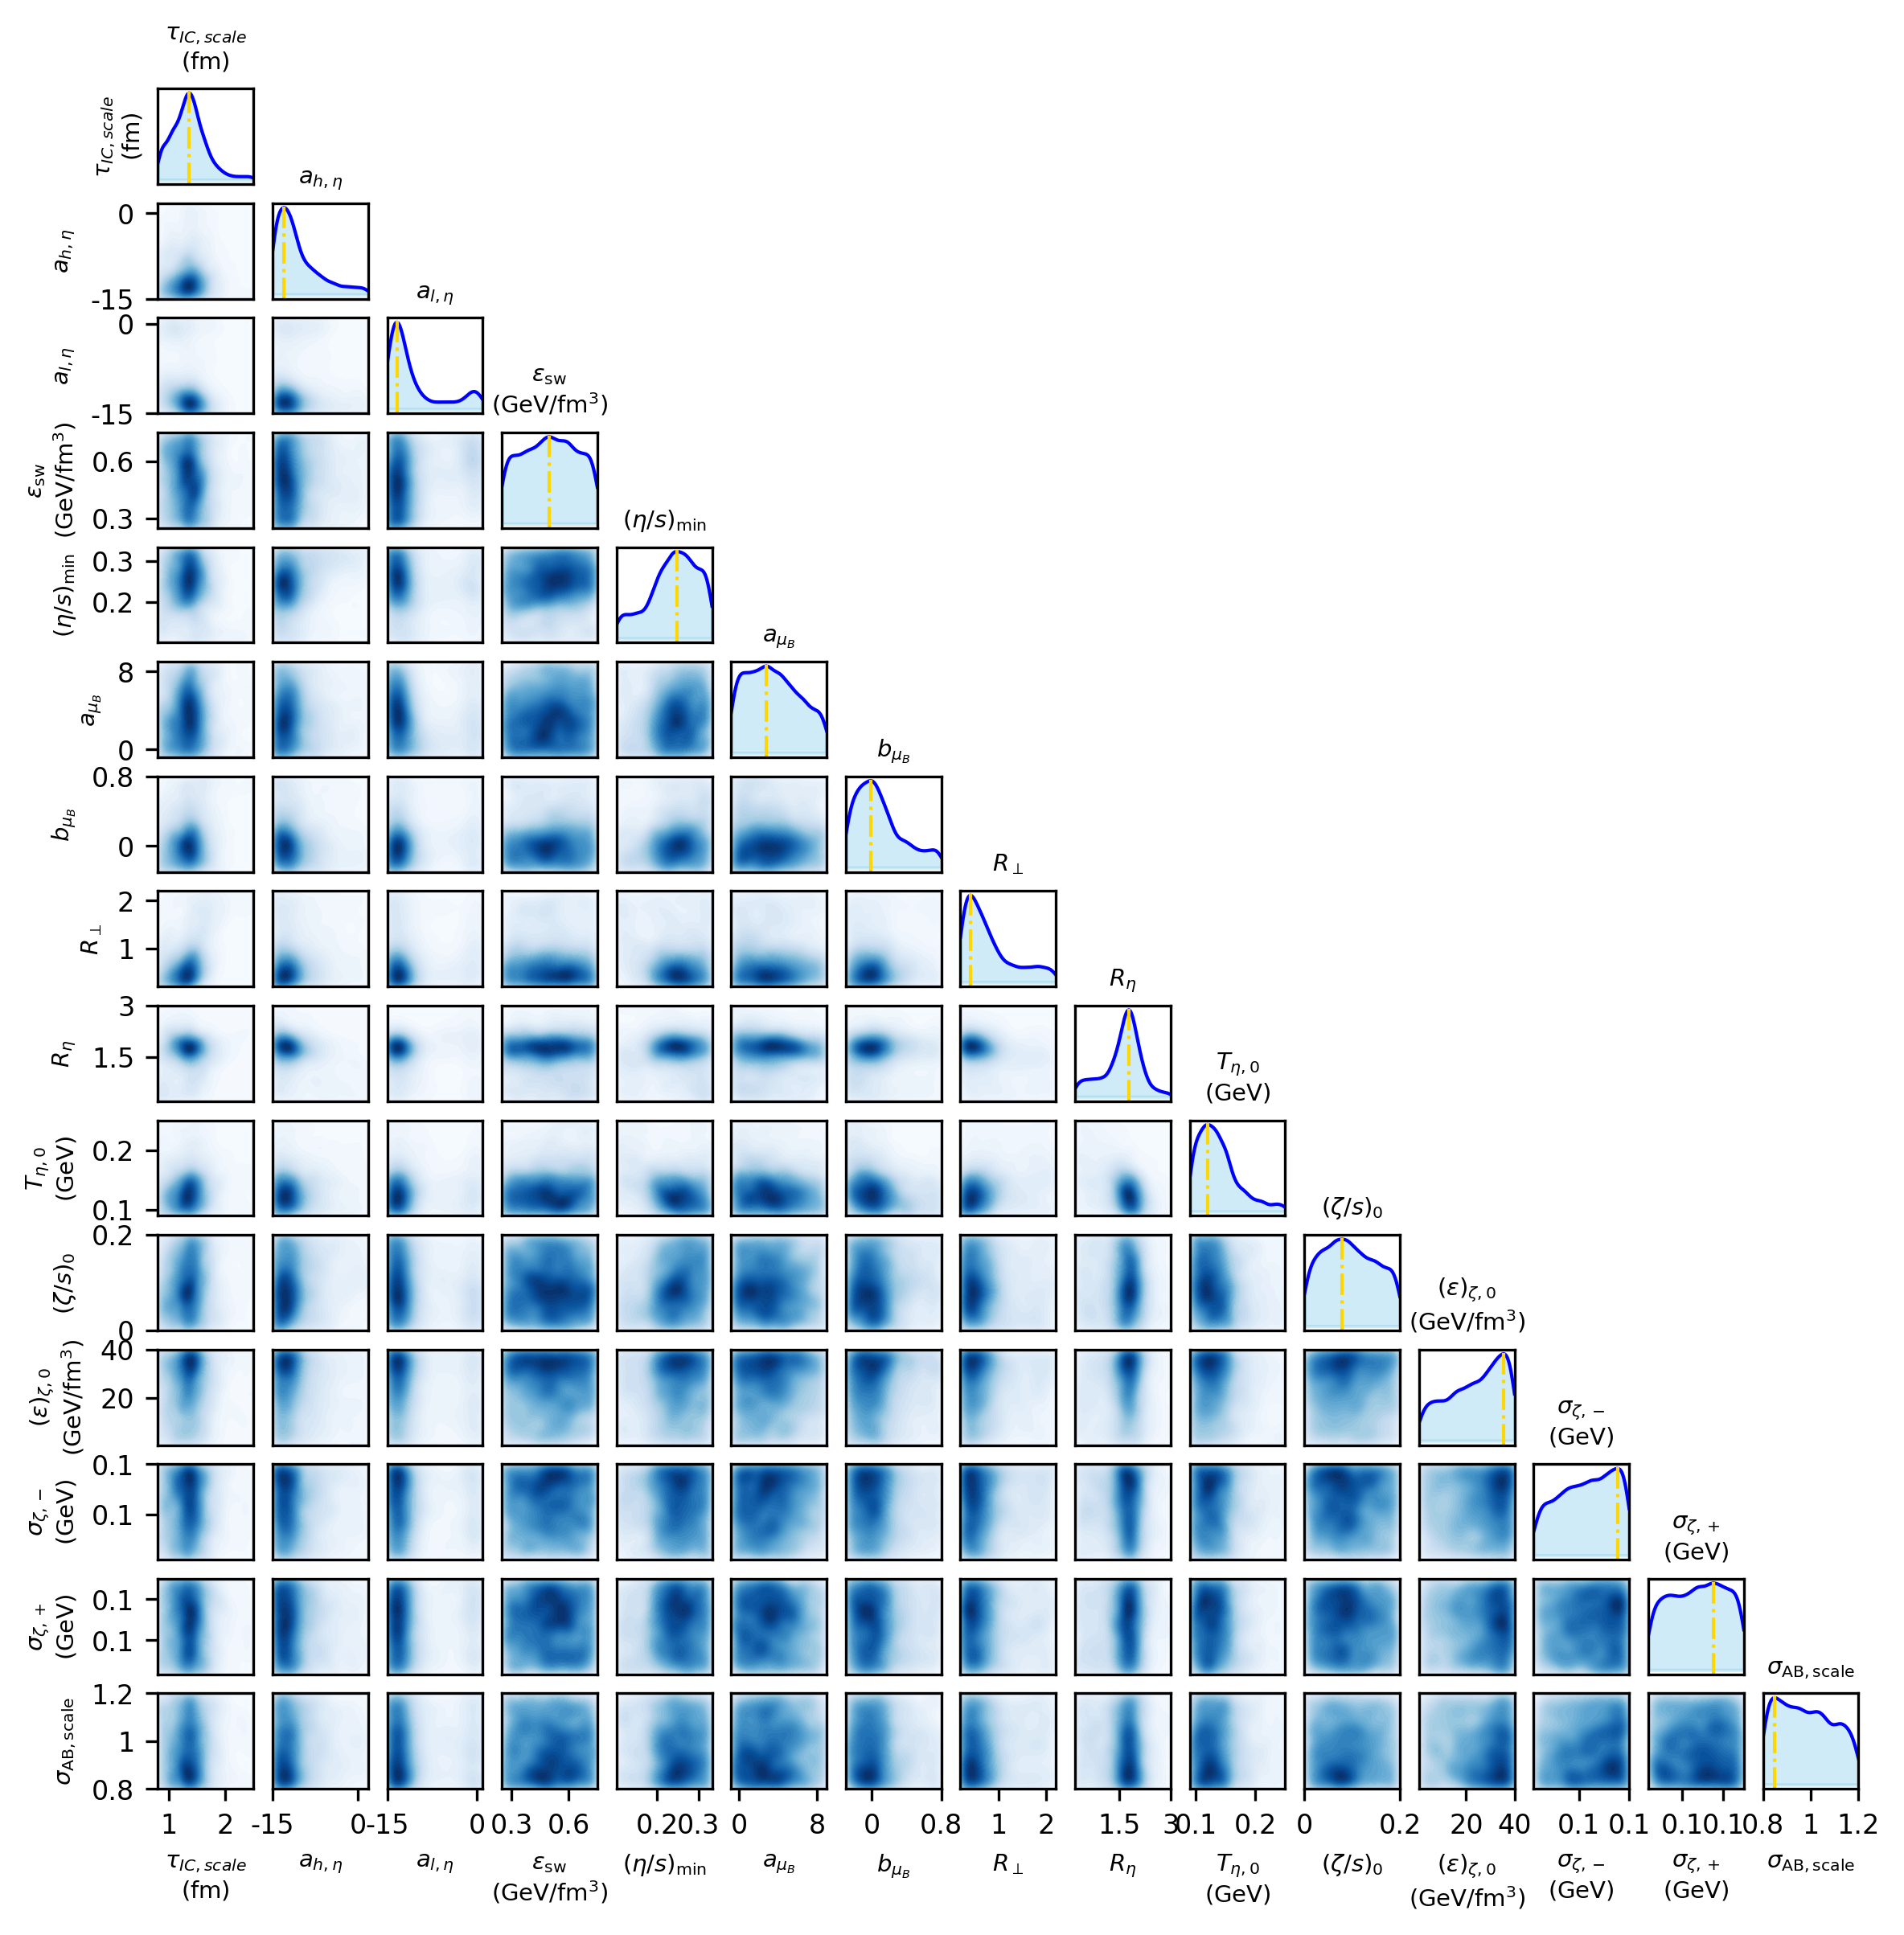

In [48]:
PARAMETER_NAMES2 = [
    r'$\tau_{IC,scale}$'+'\n'+r'$({\rm fm})$',
    r'$a_{h,\eta}$',
    r'$a_{l,\eta}$',
    r'$\epsilon_{\rm sw}$'+'\n'+r'$({\rm GeV/fm^3})$',
    r'$(\eta/s)_{\rm min}$',
    r'$a_{\mu_B}$', #etsscale_mub
    r'$b_{\mu_B}$',#etasshiftmub
    r'$R_{\perp}$',
    r'$R_{\eta}$',
    r'$T_{\eta, \rm 0}$'+'\n'+r'$({\rm GeV})$',
    r'$(\zeta/s)_{\rm 0}$',
    r'$(\epsilon)_{\zeta,\rm 0 }$'+'\n'+r'$({\rm GeV/fm^3})$',
    r'$\sigma_{\zeta, \rm -}$'+'\n'+r'$({\rm GeV})$',
    r'$\sigma_{\zeta, \rm +}$'+'\n'+r'$({\rm GeV})$',
    r'$\sigma_{\rm AB, scale}$'
]
from matplotlib.ticker import FuncFormatter, MaxNLocator
# Function to format tick labels
def format_func(value, tick_number):
    if value.is_integer():
        return f'{int(value)}'
    else:
        return f'{value:.1f}'
# Function to calculate MAP estimates
def calculate_map_estimates(posteriorSamples):
    map_estimates = []
    for i in range(posteriorSamples.shape[1]):
        kde = gaussian_kde(posteriorSamples[:, i])
        x_vals = np.linspace(np.min(posteriorSamples[:, i]), np.max(posteriorSamples[:, i]), 1000)
        kde_vals = kde(x_vals)
        mode_idx = np.argmax(kde_vals)
        map_estimates.append(x_vals[mode_idx])
    return map_estimates

# Function to plot triangle plot
def plot_triangle(posteriorSamples, PARAMETER_NAMES2):
    num_params = posteriorSamples.shape[1]
    fig = plt.figure(figsize=(7.5, 7.5), dpi=300)
    gs = gridspec.GridSpec(num_params, num_params, figure=fig)

    for i in range(num_params):
        for j in range(num_params):
            ax = fig.add_subplot(gs[i, j])
            if i == j:
                # 1D Distribution on the diagonal
                kde = gaussian_kde(posteriorSamples[:, i])
                x_vals = np.linspace(np.min(posteriorSamples[:, i]), np.max(posteriorSamples[:, i]), 1000)
                kde_vals = kde(x_vals)
                kde_vals /= np.trapz(kde_vals, x_vals)  # Normalize

                ax.plot(x_vals, kde_vals, color='b', lw=1)
                ax.fill_between(x_vals, kde_vals, color='skyblue', alpha=0.4)
                ax.axvline(mapEstimates[i], color='gold', linestyle='-.', lw=1)
                ax.set_xlim(prior_ranges[i])
                ax.set_title(f'{PARAMETER_NAMES2[i]}', fontsize=7)
            elif j < i:
                # 2D Distribution in the lower triangle
                x = posteriorSamples[:, j]
                y = posteriorSamples[:, i]
                kde = gaussian_kde([x, y])
                xi, yi = np.mgrid[np.min(x):np.max(x):100j, np.min(y):np.max(y):100j]
                zi = kde(np.vstack([xi.ravel(), yi.ravel()]))
                zi = zi.reshape(xi.shape)

                ax.contourf(xi, yi, zi, levels=50, cmap='Blues')
                ax.set_xlim([np.min(x), np.max(x)])
                ax.set_ylim([np.min(y), np.max(y)])
                ax.set_xlim(prior_ranges[j])
                ax.set_ylim(prior_ranges[i])
            else:
                ax.axis('off')  # Upper triangle

            # Set x and y labels
           # Set x and y labels
            if i == num_params - 1:
                ax.set_xlabel(PARAMETER_NAMES2[j], fontsize=7)
                ax.xaxis.set_major_formatter(FuncFormatter(format_func))
                ax.xaxis.set_major_locator(MaxNLocator(nbins=1))

            else:
                ax.set_xticks([])

            if j == 0:
                ax.set_ylabel(PARAMETER_NAMES2[i], fontsize=7)
                ax.yaxis.set_major_formatter(FuncFormatter(format_func))
                ax.yaxis.set_major_locator(MaxNLocator(nbins=1))
            else:
                ax.set_yticks([])
            if i==0 and j==0:
                ax.set_xticks([])
                ax.set_yticks([])

    plt.subplots_adjust(left=0.03, right=0.97, top=0.97, bottom=0.03)  # Adjust spacing between subplots
    #plt.tight_layout()
    #plt.savefig("./plots/full/full_triangle_"+log+"_"+pca+"_"+emu+"_"+setup+".png", dpi=300)
    #save through the interface here!
    plt.show()

# Assuming posteriorSamples and PARAMETER_NAMES are already defined
# Calculate MAP estimates
mapEstimates = calculate_map_estimates(posteriorSamples)

# Call the triangle plot function
plot_triangle(posteriorSamples, PARAMETER_NAMES2)

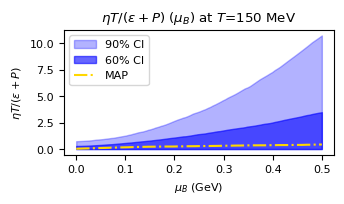

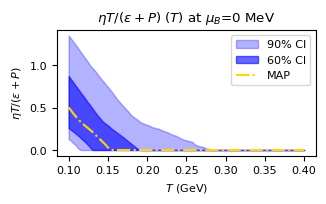

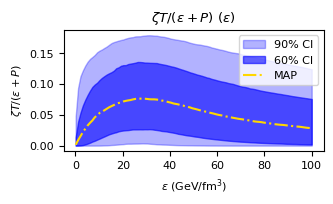

In [46]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde


# # Posterior parameter names (for reference in labels)
# PARAMETER_NAMES = [
#     r'$\tau_{IC,scale}\;[{\rm fm}]$',
#     r'$a_{h,\eta}$', r'$a_{l,\eta}$', r'$\epsilon_{\rm sw}\;[{\rm GeV/fm^3}]$',
#     r'$(\eta/s)_{\rm min}$', r'$a_{\mu_B}$', r'$b_{\mu_B}$', r'$R_{\rm g}$', 
#     r'$R_{\rm z}$', r'$T_{\eta, \rm 0}\;[{\rm GeV}]$', r'$(\zeta/s)_{\rm 0}$',
#     r'$(\epsilon)_{\zeta,\rm 0 }\;[{\rm GeV/fm^3}]$', r'$\sigma_{\zeta, \rm -}\;[{\rm GeV}]$', 
#     r'$\sigma_{\zeta, \rm +}\;[{\rm GeV}]$', r'$\sigma_{\rm AB, scale}$'
# ]

# Shear viscosity function (eta/s)
def shear_viscosity(T, muB, posterior):
    ah = posterior[1]
    al = posterior[2]
    eta_s_min = posterior[4]
    a_mu_B = posterior[5]
    b_mu_B = posterior[6]
    T_eta_0 = posterior[9]

    # Tc (temperature shift due to muB)
    Tc = T_eta_0 + b_mu_B * (muB / 0.938)
    
    # Shear viscosity as a function of T and muB
    eta_s = max(0.0, (eta_s_min + ((T > Tc) * ah * (T - Tc) + (T <= Tc) * al * (T - Tc))) * (1 + a_mu_B * (muB / 0.938)))
    return eta_s

# Bulk viscosity function (zeta/s)
def bulk_viscosity(e, posterior):
    zeta_s_0 = posterior[10]
    epsilon_zeta_0 = posterior[11]
    #print(epsilon_zeta_0)
    sigma_zeta_minus = posterior[12]
    sigma_zeta_plus = posterior[13]
    #import warnings
    #with warnings.catch_warnings(record=True) as w:
            #warnings.simplefilter("always", RuntimeWarning)  # Catch all runtime warnings

    if e < epsilon_zeta_0:
        result = zeta_s_0 * np.exp(-1.0 * ((0.103 * (e ** 0.25 - epsilon_zeta_0 ** 0.25)) ** 2) / (2.0 * sigma_zeta_minus ** 2))
    else:
        result = zeta_s_0 * np.exp(-1.0 * ((0.103 * (e ** 0.25 - epsilon_zeta_0 ** 0.25)) ** 2) / (2.0 * sigma_zeta_plus ** 2))

    # # Check if any warnings were caught
    # if len(w) > 0:
    #     for warning in w:
    #         print(f"Warning caught: {warning.message}")
    #         print(result)
    #         print(e)
    #         print(zeta_s_0)
    #         print(epsilon_zeta_0)
    #         print(sigma_zeta_minus)
    #         print(sigma_zeta_plus)
    return result
# Generate posterior distributions for shear and bulk viscosity
def generate_viscosity_distributions(posterior_samples, T_values, muB_values, e_values):
    n_samples = posterior_samples.shape[0]
    
    shear_viscosity_T_muB = np.zeros((n_samples, len(muB_values)))
    shear_viscosity_T_muB2 = np.zeros((n_samples, len(T_values)))
    bulk_viscosity_e = np.zeros((n_samples, len(e_values)))

    for i in range(n_samples):
        for j, muB in enumerate(muB_values):
            shear_viscosity_T_muB[i, j] = shear_viscosity(T=0.150, muB=muB, posterior=posterior_samples[i])
        for j, T in enumerate(T_values):
            shear_viscosity_T_muB2[i, j] = shear_viscosity(T=T, muB=0, posterior=posterior_samples[i])
        for j, e in enumerate(e_values):
            bulk_viscosity_e[i, j] = bulk_viscosity(e=e, posterior=posterior_samples[i])

    return shear_viscosity_T_muB,shear_viscosity_T_muB2, bulk_viscosity_e

# Function to plot confidence intervals
# Adjust the plot function to also plot the true model parameters
def plot_confidence_intervals_with_model(x_vals, posterior_values, map_estimate, ylabel, xlabel, title, name):

    golden_ratio = (1 + np.sqrt(5)) / 2
    width = 3.375  # 3 3/8 inches
    height = width / golden_ratio

    # Set font sizes to 8
    plt.rcParams.update({'font.size': 8})

    # Create the figure with the specified size
    plt.figure(figsize=(width, height))

    lower_90 = np.percentile(posterior_values, 5, axis=0)
    upper_90 = np.percentile(posterior_values, 95, axis=0)
    lower_60 = np.percentile(posterior_values, 20, axis=0)
    upper_60 = np.percentile(posterior_values, 80, axis=0)
    
    plt.fill_between(x_vals, lower_90, upper_90, color='blue', alpha=0.3, label='90% CI')
    plt.fill_between(x_vals, lower_60, upper_60, color='blue', alpha=0.6, label='60% CI')
    plt.plot(x_vals, map_estimate, color='gold', label='MAP', linestyle='-.')
    #plt.plot(x_vals, model_values, color='green', label='Input parameterization', linestyle='--')
    plt.xlabel(xlabel, fontsize=8)
    plt.ylabel(ylabel, fontsize=8)
    plt.title(title)
    plt.legend()
    #plt.grid(True)
    plt.tight_layout()
    plt.savefig("./plots/full/"+name+"_full_noprior_"+log+"_"+pca+"_"+emu+"_"+setup+".png", dpi=500)
    plt.show()



# Sample posteriorSamples input (1000 samples x 15 parameters)
#posteriorSamples = np.random.randn(1000, 15)

# Generate viscosities for T=150 and muB range, and for muB=0 and T range
muB_values = np.linspace(0, 0.5, 100)
T_values = np.linspace(0.100, 0.400, 100)
e_values = np.linspace(0.1, 100, 100)

shear_viscosity_T_muB,shear_viscosity_T_muB2, bulk_viscosity_e = generate_viscosity_distributions(posteriorSamples, T_values, muB_values, e_values)

def calculate_median_estimates(viscosity_samples):
    median_estimates = np.median(viscosity_samples, axis=0)
    return median_estimates

# Apply this function for the MAP estimate of each distribution:
map_shear_viscosity_T_muB = calculate_median_estimates(shear_viscosity_T_muB)
map_shear_viscosity_T_muB2 = calculate_median_estimates(shear_viscosity_T_muB2)
map_bulk_viscosity_e = calculate_median_estimates(bulk_viscosity_e)
# shear_viscosity_model_T_muB_input = np.array([shear_viscosity(T=0.150, muB=muB, posterior=parameters) for muB in muB_values])
# shear_viscosity_model_T_muB2_input = np.array([shear_viscosity(T=T, muB=0, posterior=parameters) for T in T_values])
# bulk_viscosity_model_e_input = np.array([bulk_viscosity(e=e, posterior=parameters) for e in e_values])

# Plot confidence intervals for shear viscosity
plot_confidence_intervals_with_model(muB_values, shear_viscosity_T_muB, map_shear_viscosity_T_muB,
                           ylabel=r'$\eta T/(\epsilon+P)$', xlabel=r'$\mu_B$ (GeV)', 
                          title=r'$\eta T/(\epsilon+P)$ ($\mu_B$) at $T$=150 MeV', name="etas_mub")

plot_confidence_intervals_with_model(T_values, shear_viscosity_T_muB2, map_shear_viscosity_T_muB2,
                          ylabel=r'$\eta T/(\epsilon+P)$', xlabel=r'$T$ (GeV)', 
                          title=r'$\eta T/(\epsilon+P)$ ($T$) at $\mu_B$=0 MeV', name="etas_T")

# Plot confidence intervals for bulk viscosity
plot_confidence_intervals_with_model(e_values, bulk_viscosity_e, map_bulk_viscosity_e,
                          ylabel=r'$\zeta T/(\epsilon+P)$', xlabel=r'$\epsilon$ (GeV/fm$^3$)',
                          title=r'$\zeta T/(\epsilon+P)$ ($\epsilon$)', name="bulk")


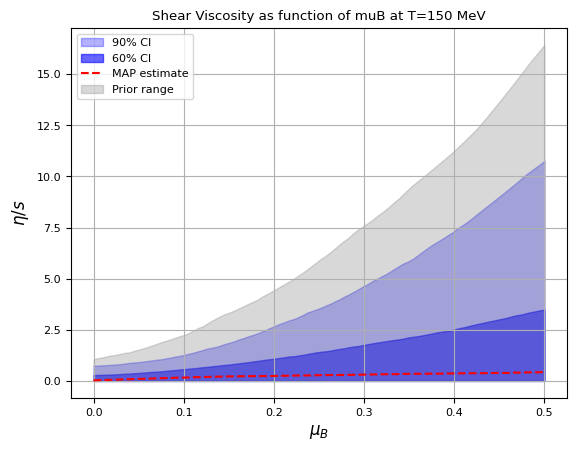

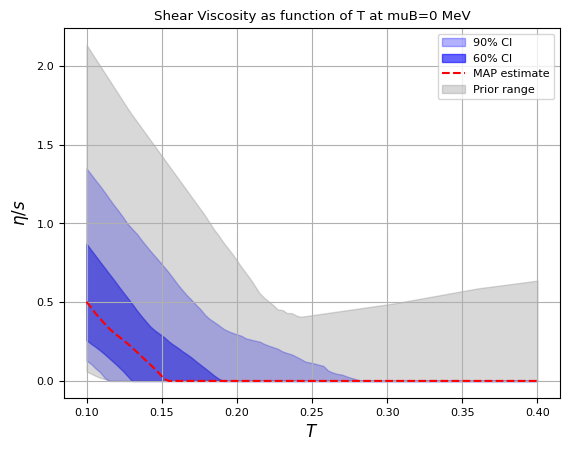

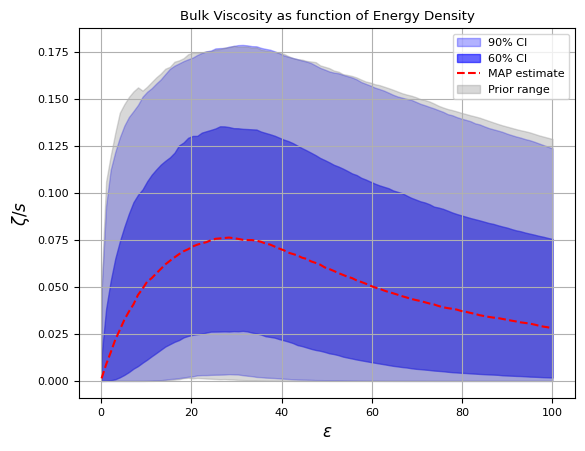

In [41]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

# # Posterior parameter names (for reference in labels)
# PARAMETER_NAMES = [
#     r'$\tau_{IC,scale}\;[{\rm fm}]$',
#     r'$a_{h,\eta}$', r'$a_{l,\eta}$', r'$\epsilon_{\rm sw}\;[{\rm GeV/fm^3}]$',
#     r'$(\eta/s)_{\rm min}$', r'$a_{\mu_B}$', r'$b_{\mu_B}$', r'$R_{\rm g}$', 
#     r'$R_{\rm z}$', r'$T_{\eta, \rm 0}\;[{\rm GeV}]$', r'$(\zeta/s)_{\rm 0}$',
#     r'$(\epsilon)_{\zeta,\rm 0 }\;[{\rm GeV/fm^3}]$', r'$\sigma_{\zeta, \rm -}\;[{\rm GeV}]$', 
#     r'$\sigma_{\zeta, \rm +}\;[{\rm GeV}]$', r'$\sigma_{\rm AB, scale}$'
# ]

# Shear viscosity function (eta/s)
def shear_viscosity(T, muB, posterior):
    ah = posterior[1]
    al = posterior[2]
    eta_s_min = posterior[4]
    a_mu_B = posterior[5]
    b_mu_B = posterior[6]
    T_eta_0 = posterior[9]

    # Tc (temperature shift due to muB)
    Tc = T_eta_0 + b_mu_B * (muB / 0.938)
    
    # Shear viscosity as a function of T and muB
    eta_s = max(0.0, (eta_s_min + ((T > Tc) * ah * (T - Tc) + (T <= Tc) * al * (T - Tc))) * (1 + a_mu_B * (muB / 0.938)))
    return eta_s

# Bulk viscosity function (zeta/s)
def bulk_viscosity(e, posterior):
    zeta_s_0 = posterior[10]
    epsilon_zeta_0 = posterior[11]
    sigma_zeta_minus = posterior[12]
    sigma_zeta_plus = posterior[13]

    if e < epsilon_zeta_0:
        result = zeta_s_0 * np.exp(-1.0 * ((0.103 * (e ** 0.25 - epsilon_zeta_0 ** 0.25)) ** 2) / (2.0 * sigma_zeta_minus ** 2))
    else:
        result = zeta_s_0 * np.exp(-1.0 * ((0.103 * (e ** 0.25 - epsilon_zeta_0 ** 0.25)) ** 2) / (2.0 * sigma_zeta_plus ** 2))

    return result

# Generate posterior distributions for shear and bulk viscosity
def generate_viscosity_distributions(posterior_samples, T_values, muB_values, e_values):
    n_samples = posterior_samples.shape[0]
    
    shear_viscosity_T_muB = np.zeros((n_samples, len(muB_values)))
    shear_viscosity_T_muB2 = np.zeros((n_samples, len(T_values)))
    bulk_viscosity_e = np.zeros((n_samples, len(e_values)))

    for i in range(n_samples):
        for j, muB in enumerate(muB_values):
            shear_viscosity_T_muB[i, j] = shear_viscosity(T=0.150, muB=muB, posterior=posterior_samples[i])
        for j, T in enumerate(T_values):
            shear_viscosity_T_muB2[i, j] = shear_viscosity(T=T, muB=0, posterior=posterior_samples[i])
        for j, e in enumerate(e_values):
            bulk_viscosity_e[i, j] = bulk_viscosity(e=e, posterior=posterior_samples[i])

    return shear_viscosity_T_muB, shear_viscosity_T_muB2, bulk_viscosity_e

def calculate_prior_range(prior_samples, T_values, muB_values, e_values):
    n_samples = prior_samples.shape[0]
    
    shear_viscosity_prior_T_muB = np.zeros((n_samples, len(muB_values)))
    shear_viscosity_prior_T_muB2 = np.zeros((n_samples, len(T_values)))
    bulk_viscosity_prior_e = np.zeros((n_samples, len(e_values)))

    for i in range(n_samples):
        for j, muB in enumerate(muB_values):
            shear_viscosity_prior_T_muB[i, j] = shear_viscosity(T=0.150, muB=muB, posterior=prior_samples[i])
        for j, T in enumerate(T_values):
            shear_viscosity_prior_T_muB2[i, j] = shear_viscosity(T=T, muB=0, posterior=prior_samples[i])
        for j, e in enumerate(e_values):
            bulk_viscosity_prior_e[i, j] = bulk_viscosity(e=e, posterior=prior_samples[i])

    # Calculate the 90% confidence interval (5th and 95th percentiles)
    shear_viscosity_prior_range_T_muB = (
        np.percentile(shear_viscosity_prior_T_muB, 5, axis=0),
        np.percentile(shear_viscosity_prior_T_muB, 95, axis=0)
    )
    shear_viscosity_prior_range_T_muB2 = (
        np.percentile(shear_viscosity_prior_T_muB2, 5, axis=0),
        np.percentile(shear_viscosity_prior_T_muB2, 99, axis=0)
    )
    bulk_viscosity_prior_range_e = (
        np.percentile(bulk_viscosity_prior_e, 5, axis=0),
        np.percentile(bulk_viscosity_prior_e, 95, axis=0)
    )

    return shear_viscosity_prior_range_T_muB, shear_viscosity_prior_range_T_muB2, bulk_viscosity_prior_range_e

# Function to plot confidence intervals with model and prior ranges
def plot_confidence_intervals_with_model(x_vals, posterior_values, map_estimate, prior_range, ylabel, xlabel, title, name):
    lower_90 = np.percentile(posterior_values, 5, axis=0)
    upper_90 = np.percentile(posterior_values, 95, axis=0)
    lower_60 = np.percentile(posterior_values, 20, axis=0)
    upper_60 = np.percentile(posterior_values, 80, axis=0)
    
    plt.fill_between(x_vals, lower_90, upper_90, color='blue', alpha=0.3, label='90% CI')
    plt.fill_between(x_vals, lower_60, upper_60, color='blue', alpha=0.6, label='60% CI')
    plt.plot(x_vals, map_estimate, color='red', label='MAP estimate', linestyle='--')
    #plt.plot(x_vals, model_values, color='green', label='Input parameterization', linestyle='--')

    # Add grey shaded prior range
    prior_min, prior_max = prior_range
    plt.fill_between(x_vals, prior_min, prior_max, color='grey', alpha=0.3, label='Prior range')

    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.savefig("./plots/full/"+name+"_full_"+log+"_"+pca+"_"+emu+"_"+setup+".png")
    plt.show()

# Sample posteriorSamples input (1000 samples x 15 parameters)
# posteriorSamples = np.random.randn(1000, 15)

# Generate viscosities for T=150 and muB range, and for muB=0 and T range
muB_values = np.linspace(0, 0.5, 100)
T_values = np.linspace(0.100, 0.400, 100)
e_values = np.linspace(0.1, 100, 100)

shear_viscosity_T_muB, shear_viscosity_T_muB2, bulk_viscosity_e = generate_viscosity_distributions(posteriorSamples, T_values, muB_values, e_values)

# Calculate prior ranges
# Function to generate samples from prior ranges
def generate_prior_samples(prior_ranges, n_samples=1000):
    n_parameters = len(prior_ranges)
    prior_samples = np.zeros((n_samples, n_parameters))
    
    for i, (low, high) in enumerate(prior_ranges):
        prior_samples[:, i] = np.random.uniform(low, high, n_samples)
    
    return prior_samples

# Generate 1000 samples from the prior ranges
prior_samples = generate_prior_samples(prior_ranges, n_samples=1000)  # Example prior samples, replace with actual prior samples
shear_viscosity_prior_range_T_muB, shear_viscosity_prior_range_T_muB2, bulk_viscosity_prior_range_e = calculate_prior_range(prior_samples, T_values, muB_values, e_values)

def calculate_median_estimates(viscosity_samples):
    median_estimates = np.median(viscosity_samples, axis=0)
    return median_estimates

# Apply this function for the MAP estimate of each distribution:
map_shear_viscosity_T_muB = calculate_median_estimates(shear_viscosity_T_muB)
map_shear_viscosity_T_muB2 = calculate_median_estimates(shear_viscosity_T_muB2)
map_bulk_viscosity_e = calculate_median_estimates(bulk_viscosity_e)
# shear_viscosity_model_T_muB_input = np.array([shear_viscosity(T=0.150, muB=muB, posterior=parameters) for muB in muB_values])
# shear_viscosity_model_T_muB2_input = np.array([shear_viscosity(T=T, muB=0, posterior=parameters) for T in T_values])
# bulk_viscosity_model_e_input = np.array([bulk_viscosity(e=e, posterior=parameters) for e in e_values])

# Plot confidence intervals for shear viscosity
plot_confidence_intervals_with_model(muB_values, shear_viscosity_T_muB, map_shear_viscosity_T_muB,shear_viscosity_prior_range_T_muB,
                          ylabel=r'$\eta/s$', xlabel=r'$\mu_B$', 
                          title='Shear Viscosity as function of muB at T=150 MeV',name="etas_mub")

plot_confidence_intervals_with_model(T_values, shear_viscosity_T_muB2, map_shear_viscosity_T_muB2, shear_viscosity_prior_range_T_muB2,
                          ylabel=r'$\eta/s$', xlabel=r'$T$', 
                          title='Shear Viscosity as function of T at muB=0 MeV', name="etas_T")

# Plot confidence intervals for bulk viscosity
plot_confidence_intervals_with_model(e_values, bulk_viscosity_e, map_bulk_viscosity_e, bulk_viscosity_prior_range_e,
                          ylabel=r'$\zeta/s$', xlabel=r'$\epsilon$',
                          title='Bulk Viscosity as function of Energy Density', name="bulk")

In [42]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Assuming posteriorSamples and postPred are already defined

# def plot_predicted_vs_input(posteriorSamples, postPred):
#     n_parameters = posteriorSamples.shape[1]
#     predicted_mean = postPred.mean(axis=1)
    
#     if posteriorSamples.shape[0] != predicted_mean.shape[0]:
#         raise ValueError("posteriorSamples and postPred must have the same number of rows.")
    
#     fig, axes = plt.subplots(n_parameters, 1, figsize=(10, 6 * n_parameters))
    
#     for i in range(n_parameters):
#         ax = axes[i] if n_parameters > 1 else axes
#         ax.scatter(posteriorSamples[:, i], predicted_mean, alpha=0.5, label='Predicted vs Input')
#         ax.set_xlabel(f'Input Parameter {i+1}')
#         ax.set_ylabel('Predicted Value')
#         ax.set_title(f'Predicted vs Input Parameter {i+1}')
#         ax.legend()
    
#     plt.tight_layout()
#     plt.show()

# def plot_residuals_vs_input(posteriorSamples, postPred):
#     predicted_mean = postPred.mean(axis=1)
    
#     if posteriorSamples.shape[0] != predicted_mean.shape[0]:
#         raise ValueError("posteriorSamples and postPred must have the same number of rows.")
    
#     residuals = predicted_mean - posteriorSamples
#     n_parameters = posteriorSamples.shape[1]
#     fig, axes = plt.subplots(n_parameters, 1, figsize=(10, 6 * n_parameters))
    
#     for i in range(n_parameters):
#         ax = axes[i] if n_parameters > 1 else axes
#         ax.scatter(posteriorSamples[:, i], residuals[:, i], alpha=0.5, label='Residuals vs Input')
#         ax.axhline(0, color='black', linestyle='--')
#         ax.set_xlabel(f'Input Parameter {i+1}')
#         ax.set_ylabel('Residual')
#         ax.set_title(f'Residuals vs Input Parameter {i+1}')
#         ax.legend()
    
#     plt.tight_layout()
#     plt.show()

# def plot_distribution_of_predictions(postPred):
#     plt.figure(figsize=(10, 6))
#     plt.hist(postPred.flatten(), bins=50, alpha=0.7, label='Predicted Data')
#     plt.xlabel('Value')
#     plt.ylabel('Frequency')
#     plt.title('Distribution of Predicted Values')
#     plt.legend()
#     plt.show()

# # Call the plotting functions
# plot_predicted_vs_input(posteriorSamples, postPred)
# plot_residuals_vs_input(posteriorSamples, postPred)
# #plot_distribution_of_predictions(postPred)

In [43]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Assuming expData and postPred are already defined
# # Plot Predicted vs. Experimental Data
# plt.figure(figsize=(10, 6))
# plt.plot(expData[0].flatten(), label='Experimental Data', color='blue')
# plt.plot(postPred.mean(axis=1), label='Predicted Data (Mean)', color='red')
# plt.fill_between(range(len(expData[0].flatten())), 
#                  postPred.mean(axis=1) - postPred.std(axis=1), 
#                  postPred.mean(axis=1) + postPred.std(axis=1), 
#                  color='red', alpha=0.3, label='Predicted Data (1 Std Dev)')
# plt.xlabel('Index')
# plt.ylabel('Value')
# plt.title('Predicted vs. Experimental Data')
# plt.legend()
# plt.show()

# # Plot Residuals
# residuals = expData[0].flatten() - postPred.mean(axis=1)
# plt.figure(figsize=(10, 6))
# plt.plot(residuals, label='Residuals', color='green')
# plt.axhline(0, color='black', linestyle='--')
# plt.xlabel('Index')
# plt.ylabel('Residual')
# plt.title('Residuals (Experimental - Predicted)')
# plt.legend()
# plt.show()

# # Plot Residuals
# residuals = abs(expData[0].flatten() - postPred.mean(axis=1))/postPred.std(axis=1)
# plt.figure(figsize=(10, 6))
# plt.plot(residuals, label='Residuals in stds', color='purple')
# plt.axhline(0, color='black', linestyle='--')
# plt.xlabel('Index')
# plt.ylabel('Residual')
# plt.title('Residuals (Experimental - Predicted)')
# plt.legend()
# plt.show()

# # # Plot Distribution of Predictions
# # plt.figure(figsize=(10, 6))
# # plt.hist(postPred.flatten(), bins=50, alpha=0.7, label='Predicted Data')
# # plt.axvline(expData[0].mean(), color='red', linestyle='dashed', linewidth=1, label='Experimental Mean')
# # plt.xlabel('Value')
# # plt.ylabel('Frequency')
# # plt.title('Distribution of Predicted Values')
# # plt.legend()
# # plt.show()

19.6 05 stareta_spectra 0 15 0
[ 62.2556391   72.18045113  80.30075188  91.35338346  99.02255639
 110.75       107.36842105 105.56390977 109.17293233  98.79699248
  91.12781955  80.52631579  71.95488722  62.70676692  54.13533835]
[ 72.66462225  84.81509476  98.38165508 113.34988083 129.65089933
 147.23652239 165.8757952  185.18006881 165.68551441 147.04346611
 129.50138331 113.20095301  98.25472222  84.70818119  72.58515927]
----
19.6 05 integrated_dNdy_kminus 15 16 1
[18.8]
[26.87037053]
----
19.6 05 integrated_dNdy_kplus 16 17 2
[29.6]
[40.23105186]
----
19.6 05 integrated_dNdy_piminus 17 18 3
[165.8]
[189.17668581]
----
19.6 05 integrated_dNdy_piplus 18 19 4
[161.4]
[181.44455991]
----
19.6 05 integrated_dNdy_p 19 20 5
[34.2]
[30.62712602]
----
19.6 05 integrated_meanpT_kminus 20 21 6
[0.571]
[0.58014369]
----
19.6 05 integrated_meanpT_kplus 21 22 7
[0.59]
[0.5763038]
----
19.6 05 integrated_meanpT_piminus 22 23 8
[0.392]
[0.39094008]
----
19.6 05 integrated_meanpT_piplus 23 24 9
[0

/tmp/ipykernel_768737/3028264409.py:133: RuntimeWarning: invalid value encountered in divide
  normalized_residuals = np.where(reordered_expData == 0, 0, np.abs(residuals) / np.sqrt(reordered_postPredstd**2 + reordered_expData_std**2))


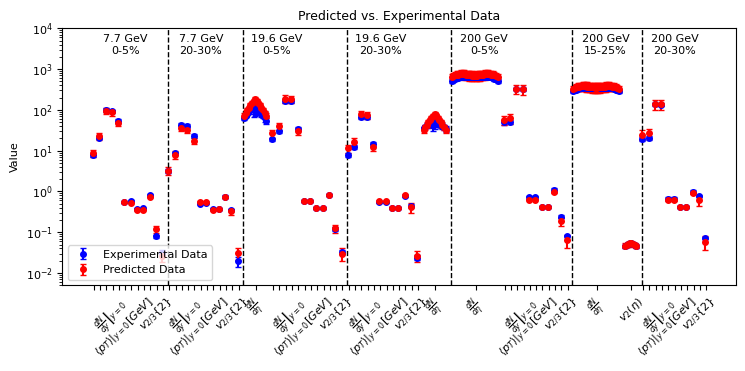

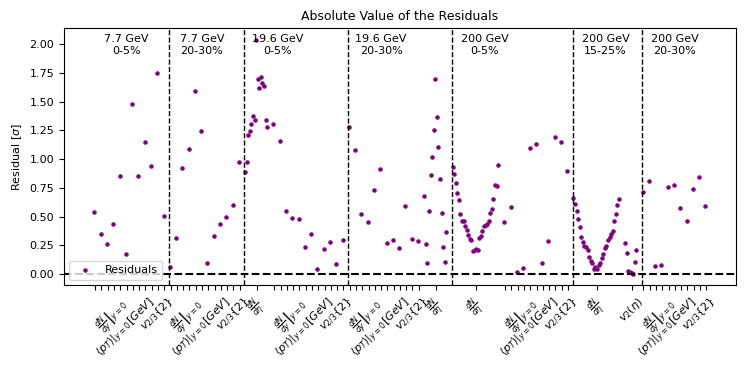

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import re
import pickle
import matplotlib.transforms as mtransforms

centrality_dict = {'05': '0-5%', '1525': '15-25%', '2030': '20-30%'}
with open(exp_path,'rb') as file:
    loaded_data = pickle.load(file)

# Function to extract info from the filename
def extract_info_from_filename(filename):
    parts = filename.split('_')
    energy = parts[1]
    centrality = parts[2]
    observable = '_'.join(parts[3:])
    return energy, centrality, observable

# Function to convert filenames to appropriate labels
def convert_to_notation(filename):
    filename = re.sub(r'(exp_|\.pkl|../latent_pickled/)', '', filename)
    filename = re.sub(r'star_v(.*)_pT', r'starv\1pt', filename)
    filename = re.sub(r'star_v', 'starv', filename)
    filename = re.sub(r'phenix_pT_v', 'phenixptv', filename)
    filename = re.sub(r'stareta_spectra', 'etas', filename)
    filename = re.sub(r'eta_spectra', 'etas', filename)
    filename = re.sub(r'y_spectra', 'ys', filename)
    filename = re.sub(r'pT_spectra', 'pTs', filename)
    filename = re.sub(r'phobos_v2_spectra', 'v2eta', filename)
    
    observables = {
        'etas': r'$\frac{dN}{d\eta}$',
        'ys': r'$\frac{dN}{dy}$',
        'pTs': r'$\frac{dN}{d(p_T)}$',
        'dNdy': r'$\left.\frac{dN}{dy}\right|_{y=0}$',
        'meanpT': r'$\langle p_T \rangle |_{y=0} [GeV]$',
        'starv2': r'$\left.v_{2/3}\right.\{2\}$',
        'starv3': r'',
        'phenixptv2': r'$v_2(p_T)$',
        'phenixptv3': r'$v_3(p_T)$',
        'starv2pt': r'$v_2(p_T)$',
        'starv3pt': r'$v_3(p_T)$',
        'v2eta': r'$v_2(\eta)$'
    }
    
    particles = {
        'kminus': r'K^-',
        'kplus': r'K^+',
        'p': 'p',
        'pbar': r'\bar{p}',
        'piminus': r'\pi^-',
        'piplus': r'\pi^+'
    }
    parts = filename.split('_')
    particle = ''
    observable = ''
    integrated = False
    for part in parts:
        if part in observables:
            observable = observables[part]
        elif part in particles:
            particle = particles[part]
        elif part == 'integrated':
            integrated = True

    if integrated and ("star" not in parts[1]) and ((parts[2] == 'piplus' and parts[1]  == 'dNdy') or (parts[2]  == 'kminus' and parts[1] == 'meanpT')):
        pass
    elif integrated and particle != '':
        observable = ''
    elif ('ys' in filename or 'pTs' in filename or integrated) and not 'star' in filename:
        observable = observable[:-1] + f'({particle})$'

    return observable

# Generate the data_list based on loaded data
data_list = []
for i, name in enumerate(loaded_data[0]["name"]):
    energy, centrality, observable = extract_info_from_filename(name)
    start = loaded_data[0]["lim"][i]
    end = loaded_data[0]["lim"][i + 1]
    data_list.append((energy, centrality, observable, start, end, i))
    print(energy, centrality, observable, start, end, i) 
    print(expData[0].flatten()[start:end])
    print(postPred.mean(axis=1)[start:end])
    print("----")

print("&&&&&&&&&&&&&&&&&&&&&&&&&")
print("&&&&&&&&&&&&&&&&&&&&&&&&&")

# Define a custom order for energies (e.g. 7.7, 19.6, 200 GeV)
energy_order = {'7.7': 0, '19.6': 1, '200': 2}
centrality_order = {'05': 0, '1525': 1, "2030": 2}

# Sort the list by energy, then by centrality
data_list.sort(key=lambda x: (energy_order[x[0]], centrality_order[x[1]]))

# Step 1: Reorder expData and postPred according to data_list
reordered_expData = []
reordered_expData_std = []
reordered_postPred = []
reordered_postPredstd = []

current_pos = 0

for energy, centrality, observable, start, end, original_index in data_list:
    # print(energy, centrality, observable, start, end, i) 
    # print(expData[0].flatten()[start:end])
    # print(postPred.mean(axis=1)[start:end])
    # print("----")
    reordered_expData.append(expData[0].flatten()[start:end])
    reordered_expData_std.append(np.sqrt(np.diagonal(expData[1])).flatten()[start:end])
    reordered_postPred.append(postPred.mean(axis=1)[start:end])
    reordered_postPredstd.append(postPred.std(axis=1)[start:end])

    # Add 2 data points with value and error 2 after each set of observables
    reordered_expData.append([0, 0,0])
    reordered_expData_std.append([0, 0,0])
    reordered_postPred.append([0, 0,0])
    reordered_postPredstd.append([0, 0,0])


# print(reordered_expData)
# print(reordered_postPred)
# Flatten the reordered lists
reordered_expData = np.concatenate(reordered_expData)
reordered_expData_std = np.concatenate(reordered_expData_std)
reordered_postPred = np.concatenate(reordered_postPred)
reordered_postPredstd = np.concatenate(reordered_postPredstd)


# Compute residuals and normalized residuals
residuals = reordered_expData - reordered_postPred
normalized_residuals = np.where(reordered_expData == 0, 0, np.abs(residuals) / np.sqrt(reordered_postPredstd**2 + reordered_expData_std**2))

# Create a mask for non-zero values
non_zero_mask = (reordered_expData != 0) & (reordered_postPred != 0)

# Create arrays for plotting, setting zero values to be invisible
plot_expData = np.where(non_zero_mask, reordered_expData, np.nan)
plot_expData_std = np.where(non_zero_mask, reordered_expData_std, 0)
plot_postPred = np.where(non_zero_mask, reordered_postPred, np.nan)
plot_postPred_std = np.where(non_zero_mask, reordered_postPredstd, 0)

plt.figure(figsize=(7.5, 7.5/2))
plt.errorbar(range(len(reordered_expData)), plot_expData, yerr=plot_expData_std, fmt='o', label='Experimental Data', color='blue', ecolor='blue', capsize=2, markersize=4)
plt.errorbar(range(len(reordered_postPred)), plot_postPred, yerr=plot_postPred_std, fmt='o', label='Predicted Data', color='red', ecolor='red', capsize=2, markersize=4)

#plt.xlabel('Observable')
plt.ylabel('Value')
plt.title('Predicted vs. Experimental Data', fontsize=9)
plt.yscale("log")
plt.ylim([5e-3,1e4])
plt.legend(loc="lower left")
current_x_pos = 0
xticksPos = []
xticksLabel = []
trans = mtransforms.blended_transform_factory(plt.gca().transData, plt.gca().transAxes)
#centrality_old=0
for i, (energy, centrality, observable, start, end, original_index) in enumerate(data_list):
    mid_pos = current_x_pos + (end - start) / 2 +3*i
    # if centrality_old != centrality and centrality_old != 0:
    #     xticksPos.append(mid_pos+3)
    # else:
    xticksPos.append(mid_pos)
    # centrality_old=centrality
    xticksLabel.append(convert_to_notation(observable))
    if i == 0:
        plt.text(current_x_pos + 3 * i + 20.5, 0.9, f'{energy} GeV\n{centrality_dict[centrality]}', 
                horizontalalignment='center', fontsize=8, transform=trans)
    if i > 0 and (data_list[i][0] != data_list[i-1][0] or data_list[i][1] != data_list[i-1][1]):
        plt.axvline(x=current_x_pos+3*i-0.5, color='black', linestyle='--', linewidth=1)
        
        # Create a transform that only affects the y-coordinate
        

        plt.text(current_x_pos + 3 * i + 20.5, 0.9, f'{energy} GeV\n{centrality_dict[centrality]}', 
                horizontalalignment='center', fontsize=8, transform=trans)
    
    current_x_pos += (end - start)

plt.xticks(xticksPos, xticksLabel, rotation=45, fontsize=8)
plt.tight_layout()
plt.savefig("./plots/full/datacomp_full_"+log+"_"+pca+"_"+emu+"_"+setup+".png", dpi=500)
plt.show()

# # Plot 2: Residuals
# plt.figure(figsize=(10, 6))
# plt.plot(residuals, label='Residuals', color='green')
# plt.axhline(0, color='black', linestyle='--')

# # Add separators and labels on x-axis
# current_x_pos = 0
# xticksPos = []
# xticksLabel = []
# trans = mtransforms.blended_transform_factory(plt.gca().transData, plt.gca().transAxes)
# for i, (energy, centrality, observable, start, end, original_index) in enumerate(data_list):
#     mid_pos = current_x_pos + (end - start) / 2 +3*i
#     xticksPos.append(mid_pos)
#     xticksLabel.append(convert_to_notation(observable))
#     if i == 0:
#         plt.text(current_x_pos + 3 * i + 20.5, 0.9, f'{energy} GeV\n{centrality}%', 
#                 horizontalalignment='center', fontsize=10, transform=trans)
#     if i > 0 and (data_list[i][0] != data_list[i-1][0] or data_list[i][1] != data_list[i-1][1]):
#         plt.axvline(x=current_x_pos+3*i-0.5, color='black', linestyle='--', linewidth=1)
        
#         # Create a transform that only affects the y-coordinate
        

#         plt.text(current_x_pos + 3 * i + 20.5, 0.9, f'{energy} GeV\n{centrality}%', 
#                 horizontalalignment='center', fontsize=10, transform=trans)
    
#     current_x_pos += (end - start)

# plt.xticks(xticksPos, xticksLabel, rotation=45, fontsize=10)
# plt.xlabel('Observable')
# plt.ylabel('Residual')
# plt.title('Residuals (Predicted - Experiment)')
# plt.legend()
# plt.tight_layout()
# plt.show()

# Plot 3: Residuals in Standard Deviations
plt.figure(figsize=(7.5, 7.5/2))
non_zero_mask = normalized_residuals != 0

# Filter the data
filtered_normalized_residuals = normalized_residuals[non_zero_mask]
filtered_indices = np.arange(len(normalized_residuals))[non_zero_mask]

# Create the scatter plot
plt.scatter(filtered_indices, filtered_normalized_residuals, label='Residuals', color='purple', s=5)
plt.axhline(0, color='black', linestyle='--')

# Add separators and labels on x-axis
current_x_pos = 0
xticksPos = []
xticksLabel = []
trans = mtransforms.blended_transform_factory(plt.gca().transData, plt.gca().transAxes)
for i, (energy, centrality, observable, start, end, original_index) in enumerate(data_list):
    mid_pos = current_x_pos + (end - start) / 2 +3*i
    xticksPos.append(mid_pos)
    xticksLabel.append(convert_to_notation(observable))
    if i == 0:
        plt.text(current_x_pos + 3 * i + 20.5, 0.9, f'{energy} GeV\n{centrality_dict[centrality]}', 
                horizontalalignment='center', fontsize=8, transform=trans)
    if i > 0 and (data_list[i][0] != data_list[i-1][0] or data_list[i][1] != data_list[i-1][1]):
        plt.axvline(x=current_x_pos+3*i-0.5, color='black', linestyle='--', linewidth=1)
        
        # Create a transform that only affects the y-coordinate

        plt.text(current_x_pos + 3 * i + 20.5, 0.9, f'{energy} GeV\n{centrality_dict[centrality]}', 
                horizontalalignment='center', fontsize=8, transform=trans)
    
    current_x_pos += (end - start)

plt.xticks(xticksPos, xticksLabel, rotation=45, fontsize=8)
#plt.xlabel('Observable')
plt.ylabel(r'Residual [$\sigma$]')
plt.title('Absolute Value of the Residuals', fontsize=9)
plt.legend(loc="lower left")
plt.tight_layout()
plt.savefig("./plots/full/residuals_full_"+log+"_"+pca+"_"+emu+"_"+setup+".png", dpi=500)
plt.show()



In [45]:
# #the closure test plotting functions

# colorList = ['k', 'r', 'g', 'y', 'c']
# cenList = np.array([2.5, 7.5, 15, 25, 35, 45, 55, 65, 75, 85, 95])
# #this plots expdata and the posterior samples as function of centrality. we have to reformulate this
# # dN/dy
# fig = plt.figure()
# for ipart in range(4):
#     plt.errorbar(cenList[:dNcencut],
#                  expData[0][:, ipart*dNcencut:(ipart+1)*dNcencut].flatten(),
#                  expData[1][ipart*dNcencut:(ipart+1)*dNcencut, ipart*dNcencut:(ipart+1)*dNcencut].diagonal(),
#                  marker='o', color='b', linestyle='')
#     for i in range(nsamples):
#         plt.plot(cenList[:dNcencut],
#                  postPred[ipart*dNcencut:(ipart+1)*dNcencut, i],
#                  linestyle='-', color=colorList[ipart], alpha=0.05)
# plt.yscale('log')
# plt.xlabel("Centrality(%)", fontsize = 12)
# plt.ylabel("log(dN/dy)", fontsize = 13)
# plt.xticks(fontsize = 12)
# plt.yticks(fontsize = 12)
# plt.savefig("dNdy200_{}.pdf".format(nameStr))

# # mean pT
# offset = 4*dNcencut
# fig = plt.figure()
# for ipart in range(4):
#     plt.errorbar(cenList[:dNcencut],
#                  expData[0][:, offset+ipart*dNcencut:offset+(ipart+1)*dNcencut].flatten(),
#                  expData[1][offset+ipart*dNcencut:offset+(ipart+1)*dNcencut, offset+ipart*dNcencut:offset+(ipart+1)*dNcencut].diagonal(),
#                  marker='o', color='b', linestyle='')
#     for i in range(nsamples):
#         plt.plot(cenList[:dNcencut],
#                  postPred[offset+ipart*dNcencut:offset+(ipart+1)*dNcencut, i],
#                  linestyle='-', color=colorList[ipart], alpha=0.05)
# plt.ylim([0, 1.5])
# plt.xlabel("Centrality(%)", fontsize = 12)
# plt.ylabel(r"$\langle p_T \rangle$", fontsize = 13)
# plt.xticks(fontsize = 12)
# plt.yticks(fontsize = 12)
# plt.savefig("meanpT200_{}.pdf".format(nameStr))

# # vn
# offset += 4*dNcencut
# fig = plt.figure()
# for ipart in range(2):
#     plt.errorbar(cenList[:vncencut],
#              expData[0][:, offset+ipart*vncencut:offset+(ipart+1)*vncencut].flatten(),
#              expData[1][offset+ipart*vncencut:offset+(ipart+1)*vncencut].diagonal(),
#              marker='o', color='b', linestyle='')
#     for i in range(nsamples):
#         plt.plot(cenList[:vncencut],
#                  postPred[offset+ipart*vncencut:offset+(ipart+1)*vncencut, i],
#                  linestyle='-', color=colorList[ipart], alpha=0.05)
# plt.ylabel(r"$v_n$", fontsize = 13 )
# plt.xlabel("Centrality(%)", fontsize = 12)
# plt.xticks(fontsize = 12)
# plt.yticks(fontsize = 12)
# plt.ylim([0., 0.12])
# plt.savefig("vn200_{}.pdf".format(nameStr))

# # dNdeta
# Nrap = 34
# rapArr = np.linspace(-3.3, 3.3, Nrap) #rapidity range different for current simulation, -3.3 to 3.3
# offset += 2*vncencut
# fig = plt.figure()
# for ipart in range(5):
#     plt.errorbar(rapArr,
#              expData[0][:,offset+ipart*Nrap:offset+(ipart+1)*Nrap].flatten(),
#              expData[1][offset+ipart*Nrap:offset+(ipart+1)*Nrap, offset+ipart*Nrap:offset+(ipart+1)*Nrap].diagonal(),
#              marker='o', color='b', linestyle='')
#     for i in range(nsamples):
#         plt.plot(rapArr,
#                  postPred[offset+ipart*Nrap:offset+(ipart+1)*Nrap, i],
#                  linestyle='-', color=colorList[ipart], alpha=0.05)

# plt.ylabel(r"$dN^{\rm ch}/d\eta$", fontsize = 13)       
# plt.xlabel("Centrality(%)", fontsize = 12)
# plt.xticks(fontsize = 12)
# plt.yticks(fontsize = 12)
# plt.savefig("dNdeta200_{}.pdf".format(nameStr))

# # v2(eta)
# offset += 5*Nrap
# v2rapArr = np.array([-4.90, -4.16, -3.41, -2.70, -2.25, -1.75, -1.26, -0.76,
#                      -0.3, 0.3, 0.76, 1.26, 1.75, 2.25, 2.70, 3.41, 4.16, 4.94])
# v2Nrap = v2rapArr.shape[0] - 4

# fig = plt.figure()
# ax = plt.axes([0.12, 0.12, 0.85, 0.85])
# plt.errorbar(v2rapArr[2:-2],
#              expData[0][:, offset : (offset+v2Nrap)].flatten(),
#              expData[1][offset:offset+v2Nrap, offset:offset+v2Nrap].diagonal(),
#              marker='o', color='b', linestyle='')
# for i in range(nsamples):
#     plt.plot(v2rapArr[2:-2],
#              postPred[offset:offset+v2Nrap, i],
#              linestyle='-', color=colorList[1], alpha=0.1)
# #for i in range(1):
# #    plt.fill_between(
# #        rapArr,
# #        postPred[offset:offset+Nrap, i] + postPredErr[offset:offset+Nrap, i],
# #        postPred[offset:offset+Nrap, i] - postPredErr[offset:offset+Nrap, i],
# #        color=colorList[1], alpha=0.05)
# plt.xlim([-4, 4])
# plt.ylim([0, 0.07])
# plt.ylabel(r"$v_n\{2\}({\rm ch})$", fontsize = 13)       
# plt.xlabel("Centrality(%)", fontsize = 12)
# plt.xticks(fontsize = 12)
# plt.yticks(fontsize = 12)
# plt.savefig("v2eta200_{}.pdf".format(nameStr))

# # dN/dy
# offset += v2Nrap
# fig = plt.figure()
# for ipart in range(3):
#     plt.errorbar(cenList[:dNcencut],
#                  expData[0][:, offset+ipart*dNcencut:offset+(ipart+1)*dNcencut].flatten(),
#                  expData[1][offset+ipart*dNcencut:offset+(ipart+1)*dNcencut, offset+ipart*dNcencut:offset+(ipart+1)*dNcencut].diagonal(),
#                  marker='o', color='b', linestyle='')
#     for i in range(nsamples):
#         plt.plot(cenList[:dNcencut],
#                  postPred[offset+ipart*dNcencut:offset+(ipart+1)*dNcencut, i],
#                  linestyle='-', color=colorList[ipart], alpha=0.05)
# plt.yscale('log')
# plt.ylabel("log(dN/dy)", fontsize = 13)       
# plt.xlabel("Centrality(%)", fontsize = 12)
# plt.xticks(fontsize = 12)
# plt.yticks(fontsize = 12)
# plt.savefig("dNdy19p6_{}.pdf".format(nameStr))

# # mean pT
# offset += 3*dNcencut
# fig = plt.figure()
# for ipart in range(4):
#     plt.errorbar(cenList[:dNcencut],
#                  expData[0][:, offset+ipart*dNcencut:offset+(ipart+1)*dNcencut].flatten(),
#                  expData[1][offset+ipart*dNcencut:offset+(ipart+1)*dNcencut, offset+ipart*dNcencut:offset+(ipart+1)*dNcencut].diagonal(),
#                  marker='o', color='b', linestyle='')
#     for i in range(nsamples):
#         plt.plot(cenList[:dNcencut],
#                  postPred[offset+ipart*dNcencut:offset+(ipart+1)*dNcencut, i],
#                  linestyle='-', color=colorList[ipart], alpha=0.05)
# plt.ylim([0, 1.5])
# plt.ylabel(r"$\langle p_T \rangle$", fontsize = 13)       
# plt.xlabel("Centrality(%)", fontsize = 12)
# plt.xticks(fontsize = 12)
# plt.yticks(fontsize = 12)
# plt.savefig("meanpT19p6_{}.pdf".format(nameStr))

# # vn
# offset += 4*dNcencut
# fig = plt.figure()
# for ipart in range(2):
#     plt.errorbar(cenList[:vncencut],
#              expData[0][:, offset+ipart*vncencut:offset+(ipart+1)*vncencut].flatten(),
#              expData[1][offset+ipart*vncencut:offset+(ipart+1)*vncencut, offset+ipart*vncencut:offset+(ipart+1)*vncencut].diagonal(),
#              marker='o', color='b', linestyle='')
#     for i in range(nsamples):
#         plt.plot(cenList[:vncencut],
#                  postPred[offset+ipart*vncencut:offset+(ipart+1)*vncencut, i],
#                  linestyle='-', color=colorList[ipart], alpha=0.05)
# plt.ylabel(r"$v_n$", fontsize = 13)
# plt.xlabel("Centrality(%)", fontsize = 12)
# plt.xticks(fontsize = 12)
# plt.yticks(fontsize = 12)
# plt.ylim([0., 0.12])

# plt.savefig("v219p6_{}.pdf".format(nameStr))

# # dNdeta
# Nrap = 34
# rapArr = np.linspace(-3.3, 3.3, Nrap)
# offset += 2*vncencut
# fig = plt.figure()
# for ipart in range(5):
#     plt.errorbar(rapArr,
#              expData[0][:, offset+ipart*Nrap:offset+(ipart+1)*Nrap].flatten(),
#              expData[1][offset+ipart*Nrap:offset+(ipart+1)*Nrap, offset+ipart*Nrap:offset+(ipart+1)*Nrap].diagonal(),
#              marker='o', color='b', linestyle='')
#     for i in range(nsamples):
#         plt.plot(rapArr,
#                  postPred[offset+ipart*Nrap:offset+(ipart+1)*Nrap, i],
#                  linestyle='-', color=colorList[ipart], alpha=0.05)
# plt.savefig("dNdeta19p6_{}.pdf".format(nameStr))
# plt.ylabel(r"$dN^{\rm ch}/d\eta$", fontsize = 13)
# plt.xlabel("Centrality(%)", fontsize = 12)
# plt.xticks(fontsize = 12)
# plt.yticks(fontsize = 12)

# # dN/dy
# offset += 5*Nrap
# fig = plt.figure()
# for ipart in range(3):
#     plt.errorbar(cenList[:dNcencut],
#                  expData[0][:,offset+ipart*dNcencut:offset+(ipart+1)*dNcencut].flatten(),
#                  expData[1][offset+ipart*dNcencut:offset+(ipart+1)*dNcencut, offset+ipart*dNcencut:offset+(ipart+1)*dNcencut].diagonal(),
#                  marker='o', color='b', linestyle='')
#     for i in range(nsamples):
#         plt.plot(cenList[:dNcencut],
#                  postPred[offset+ipart*dNcencut:offset+(ipart+1)*dNcencut, i],
#                  linestyle='-', color=colorList[ipart], alpha=0.05)
# plt.ylabel("log(dN/dy)", fontsize = 13)
# plt.xlabel("Centrality(%)", fontsize = 12)
# plt.xticks(fontsize = 12)
# plt.yticks(fontsize = 12)
# plt.savefig("dNdy7p7_{}.pdf".format(nameStr))

# # mean pT
# offset += 3*dNcencut
# fig = plt.figure()
# for ipart in range(4):
#     plt.errorbar(cenList[:dNcencut],
#                  expData[0][:,offset+ipart*dNcencut:offset+(ipart+1)*dNcencut].flatten(),
#                  expData[1][offset+ipart*dNcencut:offset+(ipart+1)*dNcencut, offset+ipart*dNcencut:offset+(ipart+1)*dNcencut].diagonal(),
#                  marker='o', color='b', linestyle='')
#     for i in range(nsamples):
#         plt.plot(cenList[:dNcencut],
#                  postPred[offset+ipart*dNcencut:offset+(ipart+1)*dNcencut, i],
#                  linestyle='-', color=colorList[ipart], alpha=0.05)
# plt.ylim([0, 1.5])
# plt.ylabel(r"$\langle p_T \rangle$", fontsize = 13)       
# plt.xlabel("Centrality(%)", fontsize = 12)
# plt.xticks(fontsize = 12)
# plt.yticks(fontsize = 12)
# plt.savefig("meanpT7p7_{}.pdf".format(nameStr))

# # vn
# offset += 4*dNcencut
# fig = plt.figure()
# for ipart in range(2):
#     plt.errorbar(cenList[:vncencut],
#              expData[0][:, offset+ipart*vncencut:offset+(ipart+1)*vncencut].flatten(),
#              expData[1][offset+ipart*vncencut:offset+(ipart+1)*vncencut, offset+ipart*vncencut:offset+(ipart+1)*vncencut].diagonal(),
#              marker='o', color='b', linestyle='')
#     for i in range(nsamples):
#         plt.plot(cenList[:vncencut],
#                  postPred[offset+ipart*vncencut:offset+(ipart+1)*vncencut, i],
#                  linestyle='-', color=colorList[ipart], alpha=0.05)
# plt.ylabel(r"$v_n$")
# plt.ylim([0., 0.12])
# plt.ylabel(r"$v_n$", fontsize = 13)
# plt.xlabel("Centrality(%)", fontsize = 12)
# plt.xticks(fontsize = 12)
# plt.yticks(fontsize = 12)
# plt.savefig("vn7p7_{}.pdf".format(nameStr))
